# CS-GY 6953 Deep Learning Mini-Project No Parameter Skip-Connection

Task: Building a ResNet model on CIFAR-10 with a constraint of 5 million parameters maximum.

In this notebook, when I refer to a paper, it is about the ResNet paper: https://arxiv.org/abs/1512.03385 <br>
Codes are developed based on excellent work here: https://github.com/kuangliu/pytorch-cifar

## 1. Possible Improvement Ideas <br>
After having a discussion, we decided to focus on the following 7 ideas and see if the performance will improve.
* Deeper Network with Less Channels <br>
According to the paper, the ResNet have an advantage of successfully learning very deep networks compared with networks without the skip-connection. As the number of parameters is limited in this assignment, we need to have less channels in each layers, use smaller kernels, or think of other approach to make the number of parameters in each layer smaller. <br>
* Trying Different Optimization Approaches <br>
The original implementation uses the Stochastic Gradient Descent as an optimizer and the CosineAnnealing for learning rate scheduler. It is worth trying using different optimizers such as Adam as well as manually controlling the learning rate. <br>
* Ensembling <br>
In our first attempt, one model achieves approx. 86% accuracy with only 2 million parameters. So, it may be interesting to develop multiple small models and ensemble the results. <br>
* Increasing Fully-Connected Layers <br>
The original model has only one FC layer. Though the FC layers tend to use lots of parameters, this might give better predictions.
* Modifying the Kernel Size of Skip-Connection <br>
The original model uses $2 \times 2$ filter in the skip-connection but changing this may result in different results. <br>
* Removing the Kernel in Skip-Connection <br>
The paper suggests the idea of identity mapping with zero-padding for the skip-connection.
* Using Regularizers; $\ell_1$, $\ell_2$, Dropout, etc. <br>
Since the main objective of the regularizers is to address the overfitting, we will work on this approach after seeing the overfitting. <br>
<br>
In this notebook, <b> I will implement the parameter-free skip-connection network </b> and compare the performance with a one with $2 \times 2$ kernels.

## 2. Building Models <br>
On P.4 in the paper, the authors suggest the identity mapping shortcut with extra zero entries padded for increasing the dimentions. They showed the experimental result on P.6, stating that the use of projection only when having dimension conflicts is slightly better. However, in this assignment's setting, we can use the saved parameters for other parts of the network.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
batch_size = 128

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])
# There are more functions for augmentation.
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data',train=False, download=True, transform=transform_test)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torchsummary import summary

import os

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"The device is {device}")

The device is cuda


In [5]:
class IdentitySkip(nn.Module):
    def __init__(self, in_planes, planes, stride=2):
        # This layer only works when in_planes <= planes. Otherwise, we need to compress the original input.
        assert in_planes <= planes, f"Error: The output channels ({planes}) are less than the input channels ({in_planes})."
        super(IdentitySkip, self).__init__()
        self.in_planes = in_planes
        self.planes = planes
        self.stride = stride
    
    def forward(self, x):
        # The paper doesn't specify how to compress the image size, e.g. 32*32 -> 16*16.
        out = F.avg_pool2d(x, self.stride) # I use the average pooling.
        pad = torch.zeros(out.size(dim=0), self.planes-self.in_planes, out.size(dim=2), out.size(dim=3), device=device)
        out = torch.cat((out, pad), 1)
        return out

class BasicBlock(nn.Module): # A residual block with 2 convolutional layers and a skip connection.
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1, identity_skip=False): # Add identity_skip parameter.
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes,      # Number of channels in the input image
                               planes,         # Number of output channels
                               kernel_size=3,  # Size of the convolution filter
                               stride=stride,  # Stride of the convolution
                               padding=1,      # Padding added to all four sides of the input, int or {'valid', 'same'}, etc.
                               # padding_mode={'zeros', 'reflect', 'replicate', 'circular'}
                               bias=False)     # If true, adds a learnable bias ot the output.
        self.bn1 = nn.BatchNorm2d(planes)      # Other parameters include eps, momentum, affine, etc.
                                               # affine=True: affine parameters being learnable.
        self.conv2 = nn.Conv2d(planes, 
                               planes, 
                               kernel_size=3,
                               stride=1,
                               padding=1,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.shortcut = nn.Sequential()        # A sequentil wrapper of layers.
        # If the dimentions of skip connection input and output don't match, do the following.
        # As an alternative solution, zero-padding is also proposed in the paper.
        if stride != 1 or in_planes != self.expansion*planes:
            if identity_skip:
                self.shortcut = IdentitySkip(in_planes, planes)
            else:
                self.shortcut = nn.Sequential(nn.Conv2d(in_planes, 
                                                        self.expansion*planes, 
                                                        kernel_size=1, 
                                                        stride=stride, 
                                                        bias=False),
                                              nn.BatchNorm2d(self.expansion*planes))
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, identity_skip=False):
        super(ResNet, self).__init__()
        self.in_planes = 32
        self.identity_skip = identity_skip
        
        self.conv1 = nn.Conv2d(3, 32, 
                               kernel_size=3, 
                               stride=1, 
                               padding=1, 
                               bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layer1 = self._make_layer(block, 32, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 64, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 128, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 256, num_blocks[3], stride=2)
        self.linear = nn.Linear(256*block.expansion, num_classes)
        
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride, self.identity_skip))
            self.in_planes = planes*block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [32]:
# model_proj: A model using a projection in skip connection when dimentions mismatch.
model_proj = ResNet(BasicBlock, [2,2,2,2]).to(device)

# model_identity: A model using the identity mapping in skip connection when dimentions mismatch.
model_identity = ResNet(BasicBlock, [2,2,2,2], identity_skip=True).to(device)

In [10]:
summary(model_proj, (3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

In [11]:
summary(model_identity, (3, 32, 32), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
            Conv2d-3           [-1, 32, 32, 32]           9,216
       BatchNorm2d-4           [-1, 32, 32, 32]              64
            Conv2d-5           [-1, 32, 32, 32]           9,216
       BatchNorm2d-6           [-1, 32, 32, 32]              64
        BasicBlock-7           [-1, 32, 32, 32]               0
            Conv2d-8           [-1, 32, 32, 32]           9,216
       BatchNorm2d-9           [-1, 32, 32, 32]              64
           Conv2d-10           [-1, 32, 32, 32]           9,216
      BatchNorm2d-11           [-1, 32, 32, 32]              64
       BasicBlock-12           [-1, 32, 32, 32]               0
           Conv2d-13           [-1, 64, 16, 16]          18,432
      BatchNorm2d-14           [-1, 64,

The number of parameters are: <br>
&emsp; With the projection: 2,797,610 <br>
&emsp; Without the projection: 2,753,706 <br>
So only 43,904 parameters are saved. <br>
In the summary of "model_proj", the saved parameters are <br>
* Conv2d-17, BatchNorm2d-18: The number of channels increases from 32 to 64. Conv2d-17 uses $1 \times 1 \times 32 \times 64 = 2048$ parameters and BatchNorm2d-18 uses $64 \times 2 = 128$ parameters. <br>
* Conv2d-29, BatchNorm2d-30: The number of channels increases from 64 to 128. Conv2d-29 uses $1 \times 1 \times 64 \times 128 = 8192$ parameters and BatchNorm2d-18 uses $128 \times 2 = 256$ parameters. <br>
* Conv2d-41, BatchNorm2d-42: The number of channels increases from 128 to 256. Conv2d-41 uses $1 \times 1 \times 128 \times 256 = 32768$ parameters and BatchNorm2d-42 uses $256 \times 2 = 512$ parameters. <br>
Thus, in total, 43904 parameters are used in the skip-connections.

## 3. Training and Comparing the Performance

In [13]:
def train(epoch):
    print('\nEpoch: %d'%epoch)
    model.train()
    train_loss = 0
    correct, total = 0, 0
    for (inputs, targets) in trainloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    acc = correct/total*100
    train_loss /= total
    print(f"Train | Loss: {round(train_loss, 4)} | Acc: {round(acc, 2)}")
    train_losses.append(train_loss)
    train_accs.append(acc)

def test(epoch):
    global train_losses, test_losses, train_accs, test_accs, best_acc
    model.eval()
    test_loss = 0
    correct, total = 0, 0
    with torch.no_grad():
        for (inputs, targets) in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    acc = correct/total*100
    test_loss /= total
    print(f"Test  | Loss: {round(test_loss, 4)} | Acc: {round(acc, 2)}")
    test_losses.append(test_loss)
    test_accs.append(acc)

In [12]:
model = model_proj
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.1, 
                      momentum=0.9, 
                      weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [14]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []
num_epochs = 50

print(f"Training the model with projection. \n")

for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()
    
train_losses_proj = train_losses
test_losses_proj = test_losses
train_accs_proj = train_accs
test_accs_proj = test_accs

Training the model with projection. 


Epoch: 0
Train | Loss: 0.0135 | Acc: 36.11
Test  | Loss: 0.0116 | Acc: 45.59

Epoch: 1
Train | Loss: 0.0099 | Acc: 54.1
Test  | Loss: 0.0093 | Acc: 59.67

Epoch: 2
Train | Loss: 0.0078 | Acc: 64.72
Test  | Loss: 0.0083 | Acc: 63.86

Epoch: 3
Train | Loss: 0.0064 | Acc: 71.03
Test  | Loss: 0.0072 | Acc: 68.64

Epoch: 4
Train | Loss: 0.0055 | Acc: 75.55
Test  | Loss: 0.0059 | Acc: 74.37

Epoch: 5
Train | Loss: 0.0049 | Acc: 78.25
Test  | Loss: 0.0056 | Acc: 76.09

Epoch: 6
Train | Loss: 0.0046 | Acc: 79.69
Test  | Loss: 0.0064 | Acc: 73.75

Epoch: 7
Train | Loss: 0.0044 | Acc: 80.76
Test  | Loss: 0.0054 | Acc: 76.59

Epoch: 8
Train | Loss: 0.0042 | Acc: 81.49
Test  | Loss: 0.0056 | Acc: 76.32

Epoch: 9
Train | Loss: 0.0041 | Acc: 82.04
Test  | Loss: 0.0049 | Acc: 79.04

Epoch: 10
Train | Loss: 0.004 | Acc: 82.48
Test  | Loss: 0.0059 | Acc: 75.86

Epoch: 11
Train | Loss: 0.0039 | Acc: 83.05
Test  | Loss: 0.0073 | Acc: 72.76

Epoch: 12
Train | Loss: 0

In [15]:
model = model_identity
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.1, 
                      momentum=0.9, 
                      weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [16]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []
num_epochs = 50

print(f"Training the model with identity mapping. \n")

for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

train_losses_identity = train_losses
test_losses_identity = test_losses
train_accs_identity = train_accs
test_accs_identity = test_accs

Training the model with identity mapping. 


Epoch: 0
Train | Loss: 0.0146 | Acc: 32.93
Test  | Loss: 0.0122 | Acc: 43.27

Epoch: 1
Train | Loss: 0.0104 | Acc: 51.66
Test  | Loss: 0.0102 | Acc: 54.07

Epoch: 2
Train | Loss: 0.0082 | Acc: 62.82
Test  | Loss: 0.0073 | Acc: 67.38

Epoch: 3
Train | Loss: 0.0066 | Acc: 70.16
Test  | Loss: 0.0072 | Acc: 67.88

Epoch: 4
Train | Loss: 0.0055 | Acc: 75.31
Test  | Loss: 0.0063 | Acc: 72.97

Epoch: 5
Train | Loss: 0.0049 | Acc: 78.22
Test  | Loss: 0.0058 | Acc: 74.99

Epoch: 6
Train | Loss: 0.0045 | Acc: 80.01
Test  | Loss: 0.005 | Acc: 78.72

Epoch: 7
Train | Loss: 0.0042 | Acc: 81.5
Test  | Loss: 0.008 | Acc: 71.16

Epoch: 8
Train | Loss: 0.004 | Acc: 82.5
Test  | Loss: 0.0055 | Acc: 76.95

Epoch: 9
Train | Loss: 0.0038 | Acc: 83.14
Test  | Loss: 0.0053 | Acc: 78.03

Epoch: 10
Train | Loss: 0.0037 | Acc: 83.85
Test  | Loss: 0.0058 | Acc: 77.0

Epoch: 11
Train | Loss: 0.0036 | Acc: 84.36
Test  | Loss: 0.0053 | Acc: 78.78

Epoch: 12
Train | Loss:

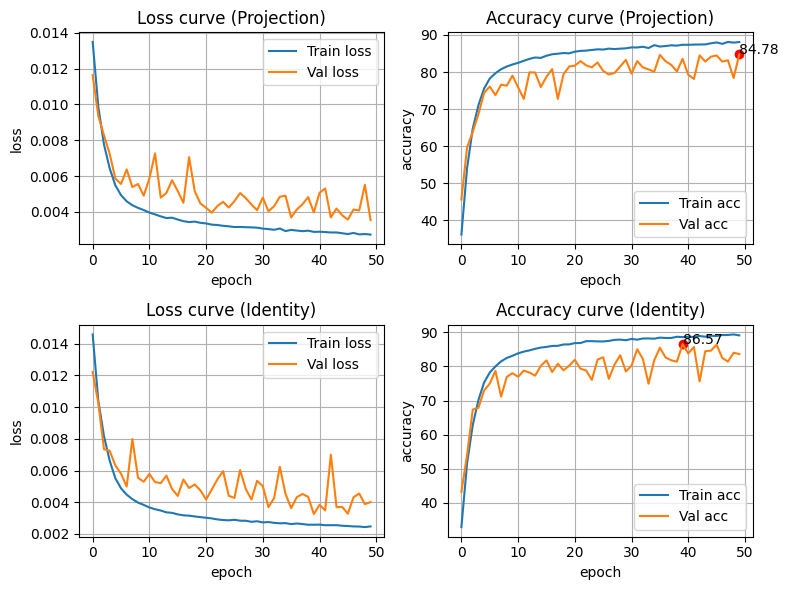

In [29]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize = (8,6))
plt.subplot(2, 2, 1)
plt.plot(range(len(train_losses_proj)), train_losses_proj, label = 'Train loss')
plt.plot(range(len(test_losses_proj)), test_losses_proj, label = 'Val loss')
plt.title('Loss curve (Projection)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(range(len(train_losses_proj)), train_accs_proj, label = 'Train acc')
plt.plot(range(len(test_losses_proj)), test_accs_proj, label = 'Val acc')
best_epoch, best_val = np.argmax(test_accs_proj), max(test_accs_proj)
plt.scatter(best_epoch, best_val, marker="o", c="r")
plt.text(best_epoch, best_val, round(best_val, 2))
plt.title('Accuracy curve (Projection)')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(range(len(train_losses_identity)), train_losses_identity, label = 'Train loss')
plt.plot(range(len(test_losses_identity)), test_losses_identity, label = 'Val loss')
plt.title('Loss curve (Identity)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(range(len(train_losses_identity)), train_accs_identity, label = 'Train acc')
plt.plot(range(len(test_losses_identity)), test_accs_identity, label = 'Val acc')
best_epoch, best_val = np.argmax(test_accs_identity), max(test_accs_identity)
plt.scatter(best_epoch, best_val, marker="o", c="r")
plt.text(best_epoch, best_val, round(best_val, 2))
plt.title('Accuracy curve (Identity)')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

In this experiment, I got 84.78% of accuracy with the projection setting, while the identity mapping results in 86.57% of accuracy. Since this result is opposite from what the paper suggests, I did the training again with more epochs.

In [33]:
model = model_proj
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.1, 
                      momentum=0.9, 
                      weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [34]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []
num_epochs = 100

print(f"Training the model with projection. \n")

for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()
    
train_losses_proj = train_losses
test_losses_proj = test_losses
train_accs_proj = train_accs
test_accs_proj = test_accs

Training the model with projection. 


Epoch: 0
Train | Loss: 0.0134 | Acc: 36.76
Test  | Loss: 0.0167 | Acc: 38.18

Epoch: 1
Train | Loss: 0.0097 | Acc: 54.97
Test  | Loss: 0.0108 | Acc: 53.62

Epoch: 2
Train | Loss: 0.0078 | Acc: 64.53
Test  | Loss: 0.0082 | Acc: 63.11

Epoch: 3
Train | Loss: 0.0065 | Acc: 70.6
Test  | Loss: 0.0059 | Acc: 73.99

Epoch: 4
Train | Loss: 0.0056 | Acc: 74.98
Test  | Loss: 0.0067 | Acc: 71.01

Epoch: 5
Train | Loss: 0.005 | Acc: 77.75
Test  | Loss: 0.0056 | Acc: 75.72

Epoch: 6
Train | Loss: 0.0047 | Acc: 79.46
Test  | Loss: 0.0054 | Acc: 76.48

Epoch: 7
Train | Loss: 0.0044 | Acc: 80.62
Test  | Loss: 0.0056 | Acc: 76.41

Epoch: 8
Train | Loss: 0.0042 | Acc: 81.27
Test  | Loss: 0.0054 | Acc: 77.42

Epoch: 9
Train | Loss: 0.0041 | Acc: 81.93
Test  | Loss: 0.0061 | Acc: 74.56

Epoch: 10
Train | Loss: 0.004 | Acc: 82.46
Test  | Loss: 0.0054 | Acc: 77.73

Epoch: 11
Train | Loss: 0.0039 | Acc: 82.73
Test  | Loss: 0.0058 | Acc: 75.23

Epoch: 12
Train | Loss: 0.

In [35]:
model = model_identity
if device == 'cuda':
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=0.1, 
                      momentum=0.9, 
                      weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

In [36]:
train_losses = []
test_losses = []
train_accs = []
test_accs = []
num_epochs = 100

print(f"Training the model with identity mapping. \n")

for epoch in range(num_epochs):
    train(epoch)
    test(epoch)
    scheduler.step()

train_losses_identity = train_losses
test_losses_identity = test_losses
train_accs_identity = train_accs
test_accs_identity = test_accs

Training the model with identity mapping. 


Epoch: 0
Train | Loss: 0.0148 | Acc: 32.23
Test  | Loss: 0.0121 | Acc: 43.14

Epoch: 1
Train | Loss: 0.0109 | Acc: 49.42
Test  | Loss: 0.0103 | Acc: 53.2

Epoch: 2
Train | Loss: 0.0085 | Acc: 61.1
Test  | Loss: 0.0078 | Acc: 64.61

Epoch: 3
Train | Loss: 0.0069 | Acc: 68.5
Test  | Loss: 0.007 | Acc: 68.78

Epoch: 4
Train | Loss: 0.0059 | Acc: 73.73
Test  | Loss: 0.0073 | Acc: 68.2

Epoch: 5
Train | Loss: 0.0051 | Acc: 77.12
Test  | Loss: 0.0074 | Acc: 69.47

Epoch: 6
Train | Loss: 0.0046 | Acc: 79.5
Test  | Loss: 0.0055 | Acc: 76.97

Epoch: 7
Train | Loss: 0.0043 | Acc: 81.07
Test  | Loss: 0.0066 | Acc: 72.16

Epoch: 8
Train | Loss: 0.0041 | Acc: 81.78
Test  | Loss: 0.0051 | Acc: 78.62

Epoch: 9
Train | Loss: 0.004 | Acc: 82.65
Test  | Loss: 0.0052 | Acc: 77.85

Epoch: 10
Train | Loss: 0.0038 | Acc: 83.22
Test  | Loss: 0.0056 | Acc: 76.28

Epoch: 11
Train | Loss: 0.0037 | Acc: 83.58
Test  | Loss: 0.005 | Acc: 79.46

Epoch: 12
Train | Loss: 0

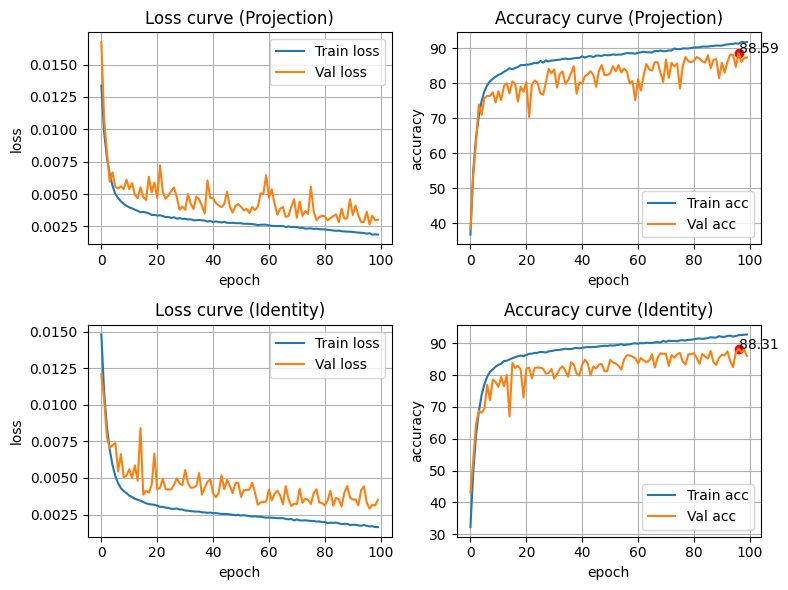

In [37]:
plt.figure(figsize = (8,6))
plt.subplot(2, 2, 1)
plt.plot(range(len(train_losses_proj)), train_losses_proj, label = 'Train loss')
plt.plot(range(len(test_losses_proj)), test_losses_proj, label = 'Val loss')
plt.title('Loss curve (Projection)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(range(len(train_losses_proj)), train_accs_proj, label = 'Train acc')
plt.plot(range(len(test_losses_proj)), test_accs_proj, label = 'Val acc')
best_epoch, best_val = np.argmax(test_accs_proj), max(test_accs_proj)
plt.scatter(best_epoch, best_val, marker="o", c="r")
plt.text(best_epoch, best_val, round(best_val, 2))
plt.title('Accuracy curve (Projection)')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(range(len(train_losses_identity)), train_losses_identity, label = 'Train loss')
plt.plot(range(len(test_losses_identity)), test_losses_identity, label = 'Val loss')
plt.title('Loss curve (Identity)')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid()
plt.legend()
plt.subplot(2, 2, 4)
plt.plot(range(len(train_losses_identity)), train_accs_identity, label = 'Train acc')
plt.plot(range(len(test_losses_identity)), test_accs_identity, label = 'Val acc')
best_epoch, best_val = np.argmax(test_accs_identity), max(test_accs_identity)
plt.scatter(best_epoch, best_val, marker="o", c="r")
plt.text(best_epoch, best_val, round(best_val, 2))
plt.title('Accuracy curve (Identity)')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

This time, the model with projection gets a slightly better accuracy than the model with identity mapping.